In [1]:
import time
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import genjax
from genjax.typing import FloatArray, IntArray, Union, PRNGKey, Tuple
from genjax import GenerativeFunction, ChoiceMap, Selection, trace

sns.set_theme(style="white")
plt.rcParams["figure.figsize"] = [9, 9]

# Pretty printing.
console = genjax.pretty(width=80)

# Reproducibility.
key = jax.random.PRNGKey(314159)

# Device management.
cpu_device = jax.devices("cpu")[0]
try:
    gpu_device = jax.devices("gpu")[0]
except:
    gpu_device = jax.devices("cpu")[0]

This notebook showcases key performance attributes of GenJAX. 

It highlights performance improvements due to parallelism, as well as the efficacy of using JAX AD to support gradient moves - however, it does not contain comparisons with other language implementations of Gen.

The hardware characteristics of my experiment device is shown below.

In [2]:
! neofetch --stdout

mccoy@pop-os 
------------ 
OS: Pop!_OS 22.04 LTS x86_64 
Kernel: 6.0.12-76060006-generic 
Uptime: 8 hours, 53 mins 
Packages: 2348 (dpkg) 
Shell: zsh 5.8.1 
Resolution: 1920x1080 
DE: GNOME 42.3.1 
WM: Mutter 
WM Theme: Pop 
Theme: Pop-dark [GTK2/3] 
Icons: Pop [GTK2/3] 
Terminal: jupyter-lab 
CPU: AMD Ryzen 9 3900XT (24) @ 4.100GHz 
GPU: NVIDIA GeForce RTX 2080 
Memory: 3299MiB / 32008MiB 



## Current modeling languages ~ static + combinators

The current set of modeling languages plus combinators is roughly equivalent to the (static modeling language plus combinators) subset of `Gen.jl`^[There are a few things that you can do beyond what is possible in the static modeling language (like use Python control flow evaluated at tracing time to perform codegen into the model) - but in general, these capabilities are syntactical sugar in nature.].

Let's create a polynomial regression model with degree selection and outlier detection.

In [3]:
# Branching model with two submodels.
switch = genjax.Switch(
    list(
        map(
            genjax.gen,
            [
                lambda pv: trace("value", genjax.Normal)(pv, 1.0),
                lambda pv: trace("value", genjax.Normal)(pv, 10.0),
            ],
        )
    )
)

# A model vectorized over `x` which calls the branching model.
@genjax.gen(genjax.Map, in_axes=(0, None, None))
def kernel(x, coefficients, basis_degrees):
    is_outlier = trace("outlier", genjax.Bernoulli)(0.08)
    is_outlier = jnp.asarray(is_outlier, dtype=int)
    polynomial_value = jnp.sum((x**basis_degrees) * coefficients)
    y = trace("y", switch)(is_outlier, polynomial_value)
    return y


# Here, `max_length` must be static at tracing time - it affects the shape
# of arrays in certain parts of the computation.
@genjax.gen
def model(xs):
    max_degree = 5
    coefficients = trace(
        "alpha", genjax.Map(genjax.TFPUniform, repeats=max_degree)
    )(-3.0, 3.0)
    basis_degrees = jnp.arange(max_degree)
    ys = trace("ys", kernel)(xs, coefficients, basis_degrees)
    return ys

Here, let's make a trace and examine it.

In [4]:
data = jnp.arange(-2.0, 2.0, 0.05)
key, tr = jax.jit(model.simulate)(key, (data,))
tr

BuiltinTrace
├── gen_fn
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function model>
├── args
│   └── tuple
│       └──  f32[80]
├── retval
│   └──  f32[80]
├── choices
│   └── Trie
│       ├── :alpha
│       │   └── MapTrace
│       │       ├── gen_fn
│       │       │   └── MapCombinator
│       │       │       ├── in_axes
│       │       │       │   └── (const) None
│       │       │       ├── repeats
│       │       │       │   └── (const) 5
│       │       │       └── kernel
│       │       │           └── TFPDistribution
│       │       │               └── distribution
│       │       │                   └── (const) <class 
│       │       │                       'tensorflow_probability.substrates.jax.distributions.uniform.Uniform'>
│       │       ├── indices
│       │       │   └──  i32[5]
│       │       ├── inner
│       │       │   └── DistributionTrace
│       │       │       ├── gen_fn
│       │       │       │   └── TFPDistribution
│       │       │       │       └── distribution
│       │       │       │           └── (const) <class 
│       │       │       │               'tensorflow_probability.substrates.jax.distributions.uniform.Uniform'>
│       │       │       ├── args
│       │       │       │   └── tuple
│       │       │       │       ├──  f32[5]
│       │       │       │       └──  f32[5]
│       │       │       ├── value
│       │       │       │   └──  f32[5]
│       │       │       └── score
│       │       │           └──  f32[5]
│       │       └── score
│       │           └──  f32[]
│       └── :ys
│           └── MapTrace
│               ├── gen_fn
│               │   └── MapCombinator
│               │       ├── in_axes
│               │       │   └── tuple
│               │       │       ├── (const) 0
│               │       │       ├── (const) None
│               │       │       └── (const) None
│               │       ├── repeats
│               │       │   └── (const) None
│               │       └── kernel
│               │           └── BuiltinGenerativeFunction
│               │               └── source
│               │                   └── <function kernel>
│               ├── indices
│               │   └──  i32[80]
│               ├── inner
│               │   └── BuiltinTrace
│               │       ├── gen_fn
│               │       │   └── BuiltinGenerativeFunction
│               │       │       └── source
│               │       │           └── <function kernel>
│               │       ├── args
│               │       │   └── tuple
│               │       │       ├──  f32[80]
│               │       │       ├──  f32[80,5]
│               │       │       └──  i32[80,5]
│               │       ├── retval
│               │       │   └──  f32[80]
│               │       ├── choices
│               │       │   └── Trie
│               │       │       ├── :outlier
│               │       │       │   └── DistributionTrace
│               │       │       │       ├── gen_fn
│               │       │       │       │   └── _Bernoulli
│               │       │       │       ├── args
│               │       │       │       │   └── tuple
│               │       │       │       │       └──  f32[80]
│               │       │       │       ├── value
│               │       │       │       │   └──  bool[80]
│               │       │       │       └── score
│               │       │       │           └──  f32[80]
│               │       │       └── :y
│               │       │           └── SwitchTrace
│               │       │               ├── gen_fn
│               │       │               │   └── SwitchCombinator
│               │       │               │       └── branches
│               │       │               │           └── list
│               │       │               │               ├── BuiltinGenerativeFunction
│               │       │               │               │   └── source
│               │       │               │               │       └── <function <la

Let's visualize some samples from our model.

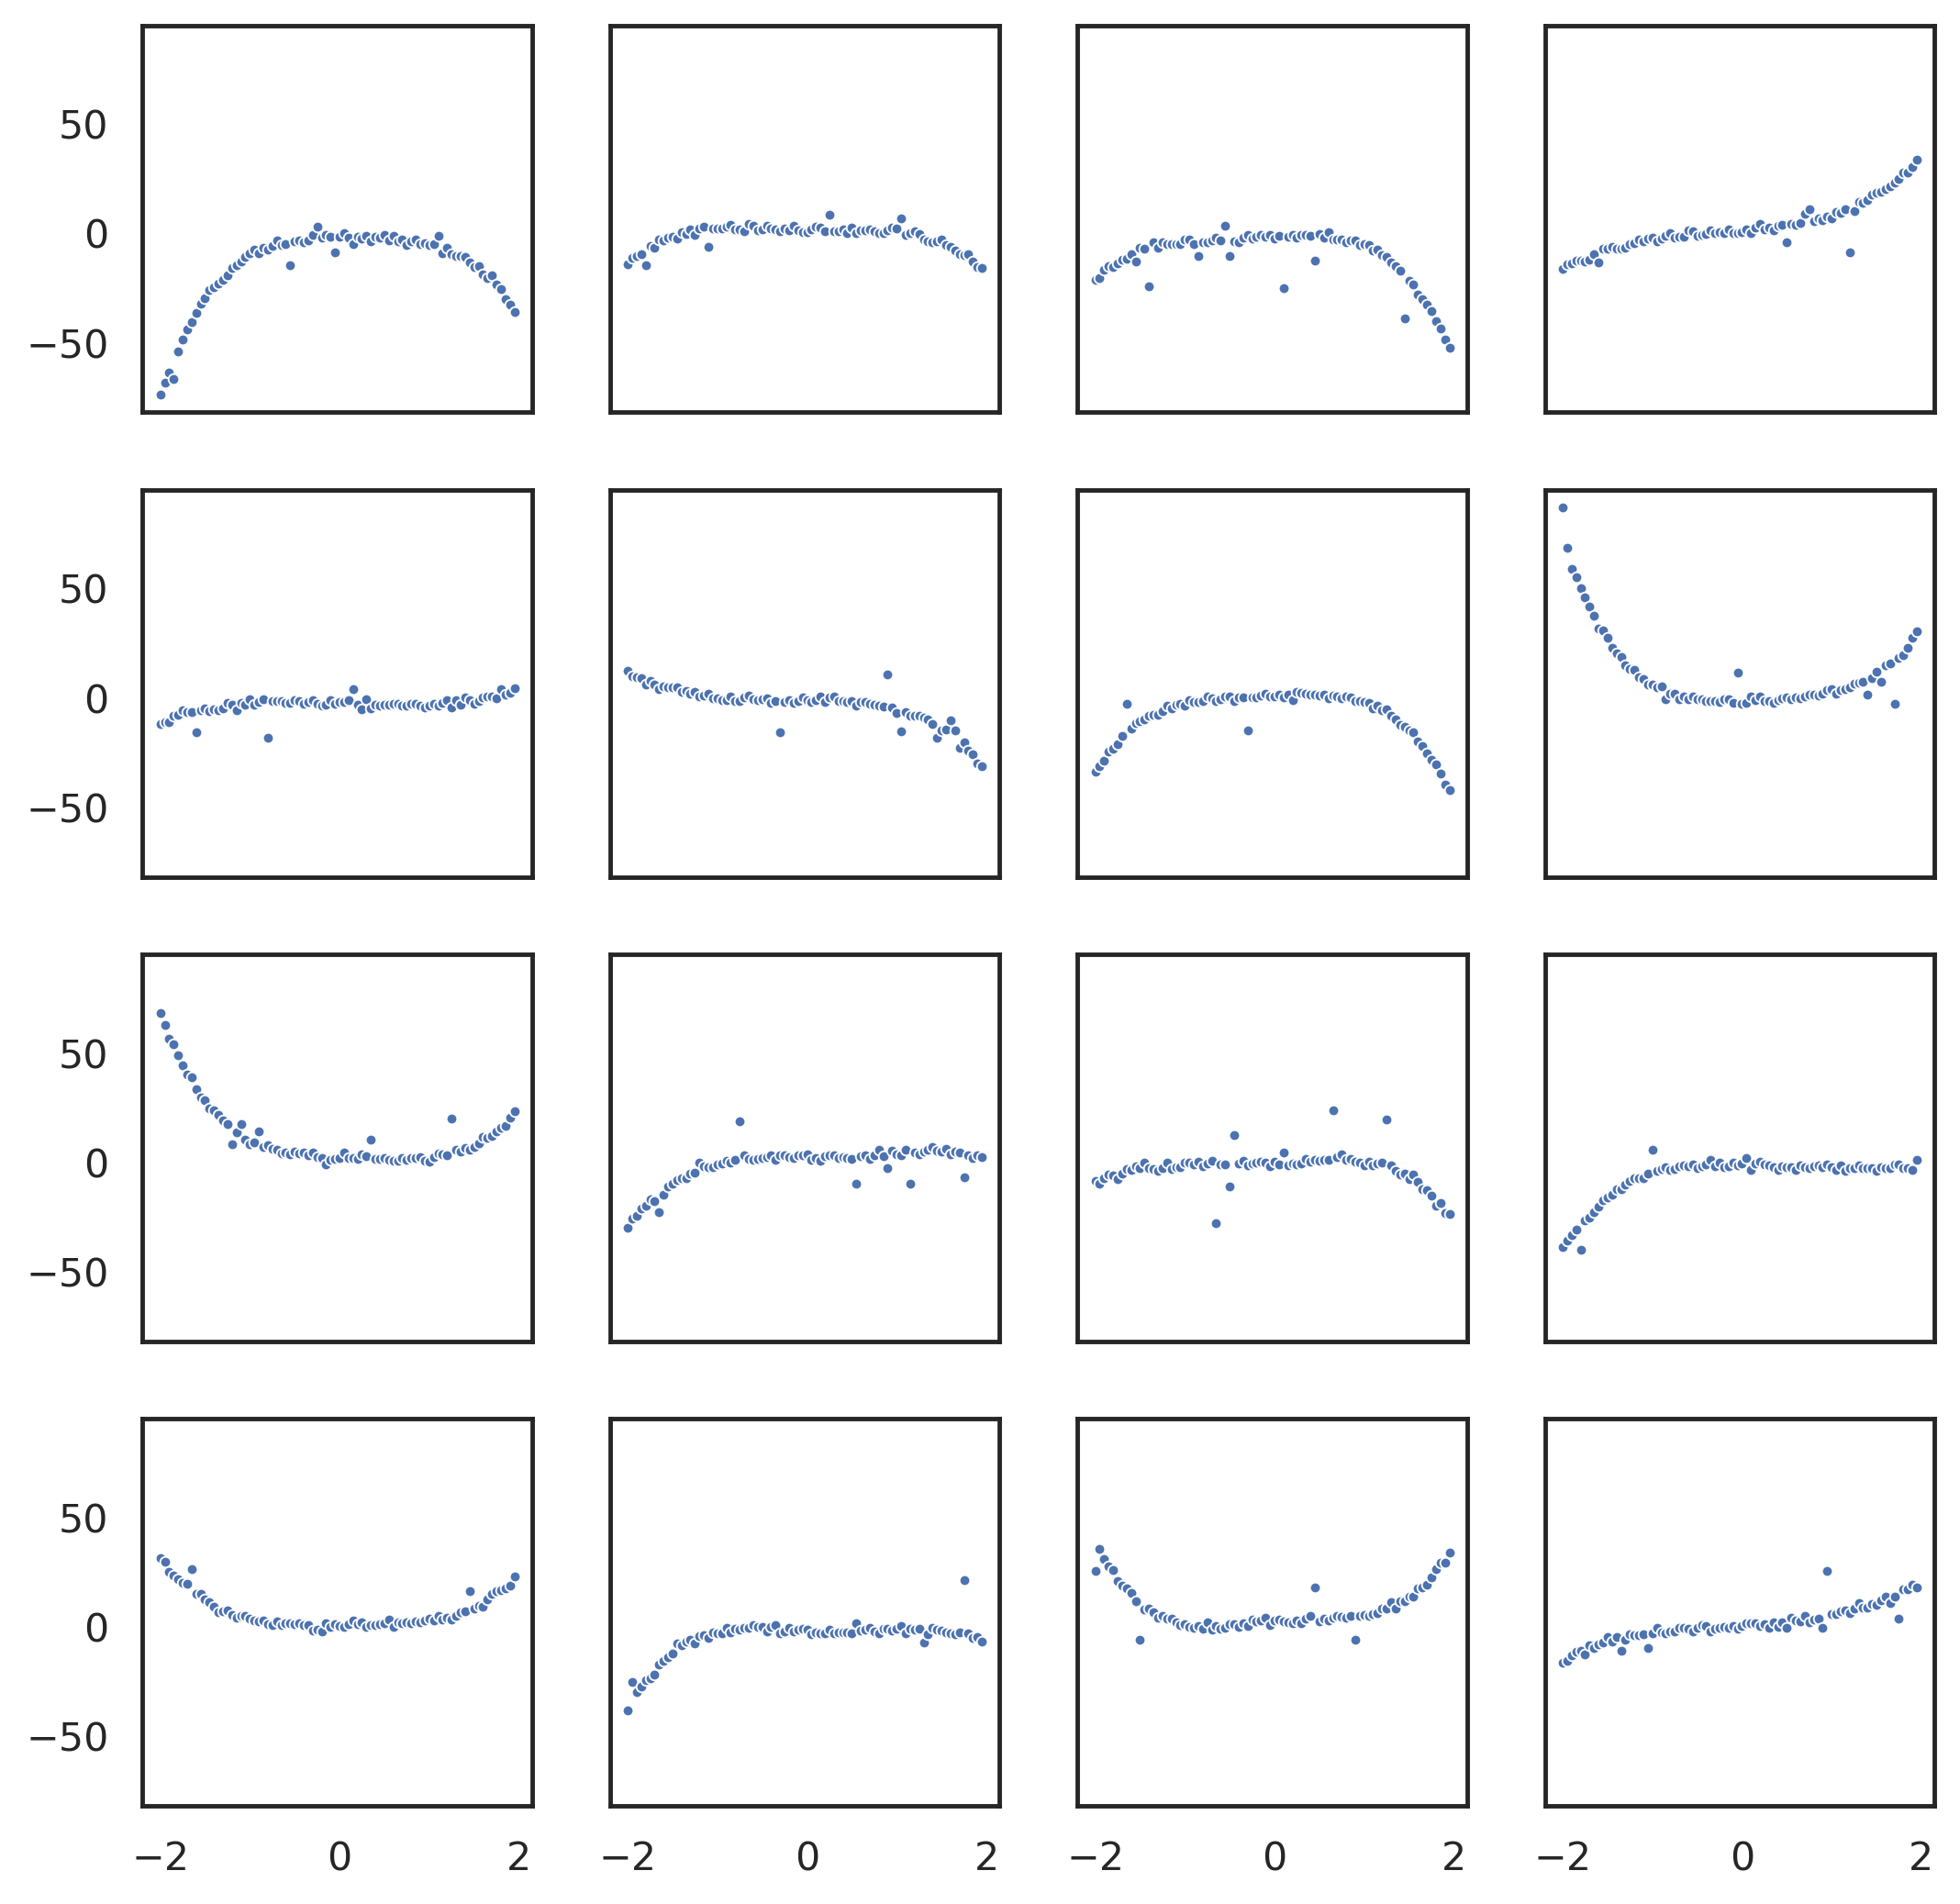

In [5]:
def viz(ax, x, y, **kwargs):
    sns.scatterplot(x=x, y=y, ax=ax, **kwargs)


f, axes = plt.subplots(4, 4, sharex=True, sharey=True, dpi=280)
jitted = jax.jit(model.simulate)
for ax in axes.flatten():
    key, tr = jitted(key, (data,))
    x = data
    y = tr.get_retval()
    viz(ax, x, y, marker=".")

plt.show()

## Importance sampling + (CPU vs. GPU)

Importance sampling (and SIR) are embarrassingly parallel. We can run an importance sampling routine and compare the performance characteristics on different devices.

In [6]:
(genjax.ImportanceSampling, genjax.SamplingImportanceResampling)

(
    <class 'genjax._src.inference.importance_sampling.ImportanceSampling'>,
    <class 'genjax._src.inference.importance_sampling.SamplingImportanceResampling'>
)

Just for enlightenment - let's briefly look at the code for `ImportanceSampling`.

In [7]:
@dataclasses.dataclass
class ImportanceSampling(genjax.Pytree):
    num_particles: IntArray
    model: GenerativeFunction
    proposal: Union[None, GenerativeFunction] = None

    def flatten(self):
        return (), (self.num_particles, self.model, self.proposal)

    @classmethod
    def new(
        cls,
        num_particles: IntArray,
        model: GenerativeFunction,
        proposal: Union[None, GenerativeFunction] = None,
    ):
        return ImportanceSampling(
            num_particles,
            model,
            proposal=proposal,
        )

    def _bootstrap_importance_sampling(
        self,
        key: PRNGKey,
        observations: ChoiceMap,
        model_args: Tuple,
    ):
        key, *sub_keys = jax.random.split(key, self.num_particles + 1)
        sub_keys = jnp.array(sub_keys)
        _, (lws, trs) = jax.vmap(
            self.model.importance, in_axes=(0, None, None)
        )(
            sub_keys,
            observations,
            model_args,
        )
        log_total_weight = jax.scipy.special.logsumexp(lws)
        log_normalized_weights = lws - log_total_weight
        log_ml_estimate = log_total_weight - jnp.log(self.num_particles)
        return key, (trs, log_normalized_weights, log_ml_estimate)

    def _proposal_importance_sampling(
        self,
        key: PRNGKey,
        observations: ChoiceMap,
        model_args: Tuple,
        proposal_args: Tuple,
    ):
        key, *sub_keys = jax.random.split(key, self.num_particles + 1)
        sub_keys = jnp.array(sub_keys)
        _, p_trs = jax.vmap(self.proposal.simulate, in_axes=(0, None, None))(
            sub_keys,
            observations,
            proposal_args,
        )
        observations = jax.tree_util.map(
            lambda v: jnp.repeats(v, self.num_particles), observations
        )
        chm = p_trs.get_choices().merge(observations)
        key, *sub_keys = jax.random.split(key, self.num_particles + 1)
        sub_keys = jnp.array(sub_keys)
        _, (lws, m_trs) = jax.vmap(
            self.model.importance, in_axes=(0, 0, None)
        )(
            sub_keys,
            chm,
            model_args,
        )
        lws = lws - p_trs.get_score()
        log_total_weight = jax.scipy.special.logsumexp(lws)
        log_normalized_weights = lws - log_total_weight
        log_ml_estimate = log_total_weight - jnp.log(self.num_particles)
        return key, (m_trs, log_normalized_weights, log_ml_estimate)

    def apply(self, key, choice_map: ChoiceMap, *args):
        # Importance sampling with custom proposal branch.
        if len(args) == 2:
            assert isinstance(args[0], tuple)
            assert isinstance(args[1], tuple)
            assert self.proposal is not None
            model_args = args[0]
            proposal_args = args[1]
            return self._proposal_importance_sampling(
                key, choice_map, model_args, proposal_args
            )
        # Bootstrap importance sampling branch.
        else:
            assert isinstance(args, tuple)
            assert self.proposal is None
            model_args = args[0]
            return self._bootstrap_importance_sampling(
                key, choice_map, model_args
            )

    def __call__(self, key, choice_map: ChoiceMap, *args):
        return self.apply(key, choice_map, *args)

Before we consider invoking this, let's write a ground truth process which we can parametrize by the number of data points.

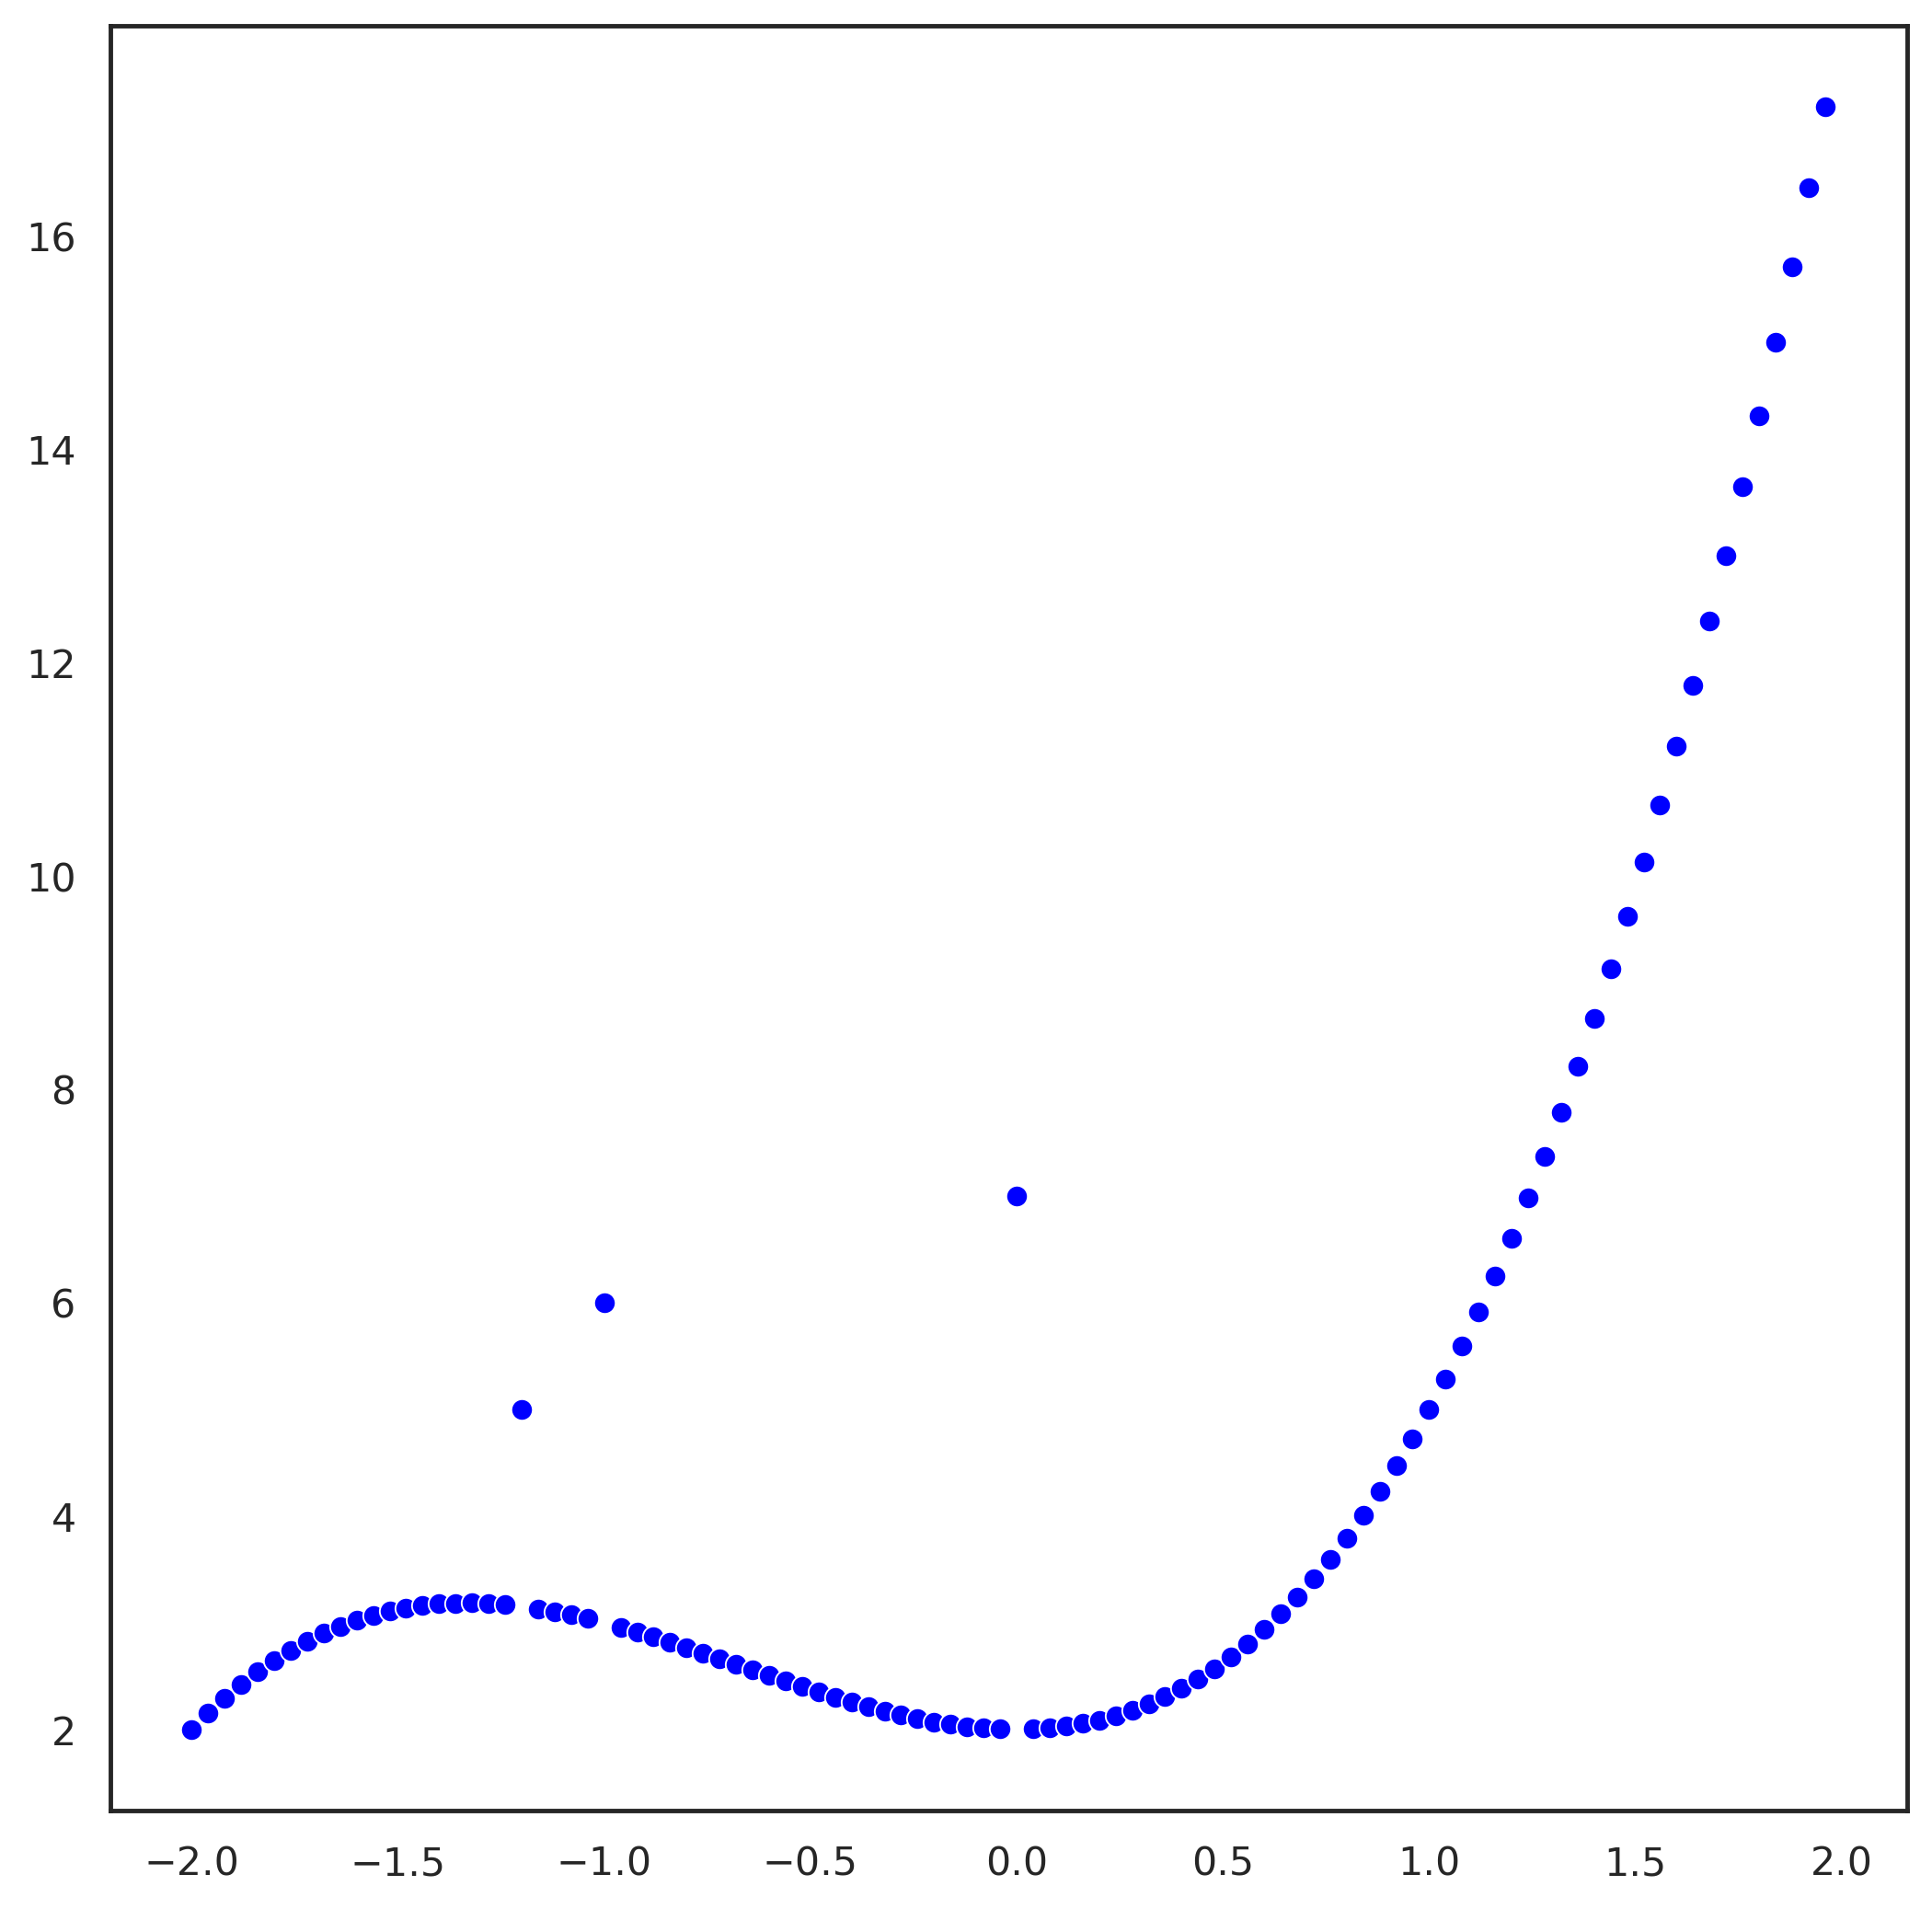

In [8]:
def make_data(num_data_points):
    data = np.arange(-2.0, 2.0, 4.0 / num_data_points)
    y = 2.0 * data**2 + 2.0 + data**3
    y[int(num_data_points / 2)] = 7.0
    y[int(num_data_points / 4)] = 6.0
    y[int(num_data_points / 5)] = 5.0
    return data, y


data, y = make_data(100)
fig_data, ax_data = plt.subplots(dpi=280)
viz(ax_data, data, y, color="blue")

In [9]:
observations = genjax.choice_map(
    {"ys": genjax.vector_choice_map(genjax.choice_map({("y", "value"): y}))}
)
observations

BuiltinChoiceMap
└── trie
    └── Trie
        └── :ys
            └── VectorChoiceMap
                ├── indices
                │   └── (numpy) i64[100]
                └── inner
                    └── BuiltinChoiceMap
                        └── trie
                            └── Trie
                                └── :y
                                    └── Trie
                                        └── :value
                                            └── ValueChoiceMap
                                                └── value
                                                    └── (numpy) f64[100]

Here, `VectorChoiceMap` communicates constraints to `MapCombinator` (as well as `UnfoldCombinator`, but that's not featured in our model right now).

The indices describe, for each leaf element of the struct-of-array choice map shadowed by the `VectorChoiceMap`, what index of the `Map` invocation the value came from.

In [10]:
observations["ys"].indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

To invoke importance sampling, we can instantiate an instance of `ImportanceSampling`.

In [11]:
# 1000 particles.
inf = genjax.ImportanceSampling.new(1000, model)

Here, because I want a convenient way to show the inference results, I'm actually going to use sampling importance resampling - allowing me to sample a single sample from the approximate posterior induced by importance sampling.

In [12]:
inf = genjax.SamplingImportanceResampling.new(1000, model)
inf

SamplingImportanceResampling
├── num_particles
│   └── (const) 1000
├── model
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function model>
└── proposal
    └── (const) None

Let's plot inference results using SIR to return single sample from the approximate posterior induced by importance sampling.

In [13]:
# Evaluate a polynomial at x.
def polynomial_at_x(x, coefficients):
    v = jnp.arange(len(coefficients))
    basis = x**v
    polynomial_value = jnp.sum(coefficients * basis)
    return polynomial_value


poly_eval = jax.jit(jax.vmap(polynomial_at_x, in_axes=(0, None)))


def plot_polynomial_values(ax, x, coefficients, **kwargs):
    v = poly_eval(x, coefficients)
    ax.scatter(x, v, **kwargs)

Below, we showcase 16 runs of SIR - we highlight outlier predictions in a `green` color, and the polynomial induced by the coefficients from the posterior sample is plotted in `light gold`.

CPU times: user 618 µs, sys: 0 ns, total: 618 µs
Wall time: 401 µs


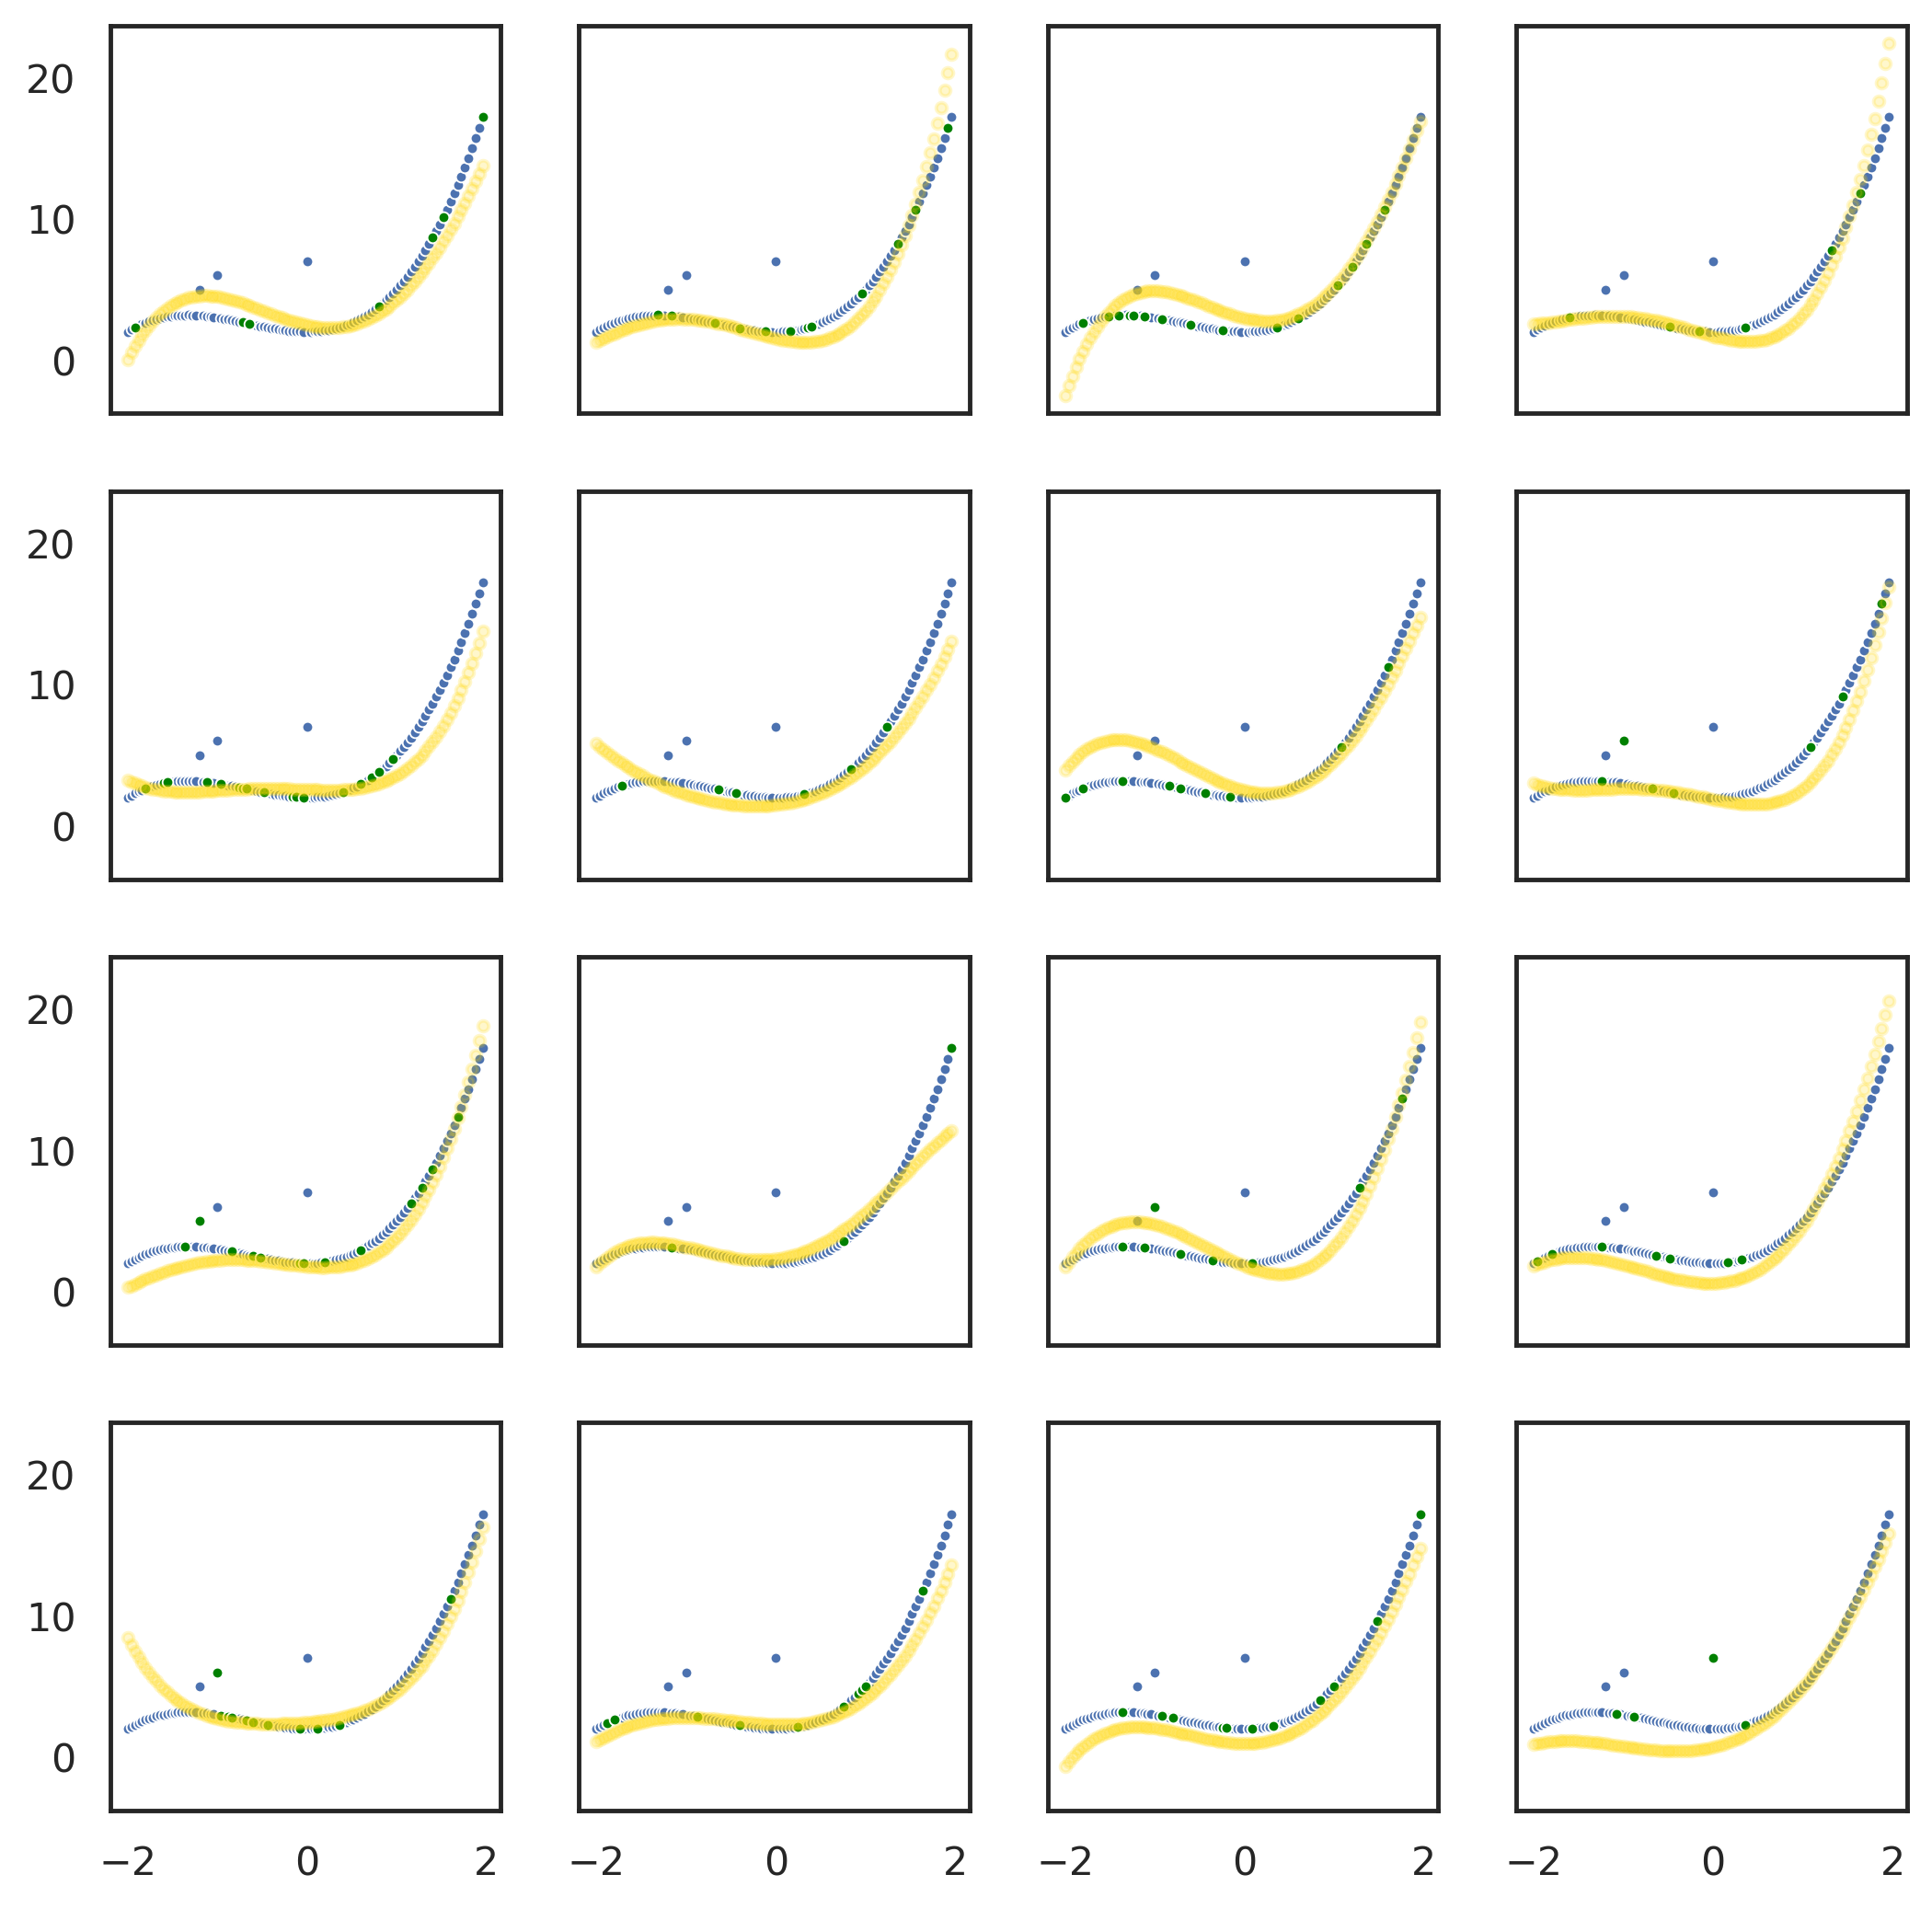

In [14]:
# Sampling importance resampling
inf = genjax.sir(1000, model)
x, y = make_data(100)
observations = genjax.choice_map(
    {"ys": genjax.vector_choice_map(genjax.choice_map({("y", "value"): y}))}
)
jitted = jax.jit(inf.apply)
# Warmup.
key, (tr, _, _) = jitted(key, observations, (x,))
%time key, (tr, _, _) = jitted(key, observations, (x, ))

# Make plots.
f, axes = plt.subplots(4, 4, sharex=True, sharey=True, dpi=280)
for ax in axes.flatten():
    key, (tr, _, _) = jitted(key, observations, (x,))
    coefficients = tr["alpha"].inner.get_retval()
    outliers = tr["ys"].indices[tr["ys", "outlier"]]
    viz(ax, x, y, marker=".")
    viz(ax, x[outliers], y[outliers], marker=".", color="green")
    plot_polynomial_values(
        ax, data, coefficients, marker=".", alpha=0.2, color="gold"
    )

plt.show()

Now, the inferences aren't the best - we'll fix that in a moment...

But notice the runtime - at least for me, that feels comparable to Julia - and it makes sense, we've eliminated all the Python overhead in the hot inference code.

But that timing was utilizing the CPU - and internally importance sampling calls `vmap`, which supports multi-threading parallelism on devices which support it.

Let's move on to benchmarking, and now we'll get to compare the CPU execution to the GPU.

### Benchmarking importance sampling

Later on, we'll add ingredients to our importance sampling routine (like rejuvenation) - so here, we'll make the benchmark code re-usable.

In [15]:
def benchmark(key, inf, *args, iters=100, device=jax.devices()[0]):
    jitted = jax.jit(inf, device=device)
    # warmup
    key, _ = jitted(key, *args)
    times = []
    for i in range(0, iters):
        start = time.time()
        key, v = jitted(key, *args)
        v.block_until_ready()  # force
        stop = time.time()
        times.append(stop - start)
    return key, np.array(times)

In [16]:
# 1000 particles.
inf = genjax.ImportanceSampling.new(1000, model)

CPU times: user 1min 20s, sys: 3.42 s, total: 1min 23s
Wall time: 18 s
CPU times: user 2min 13s, sys: 4.62 s, total: 2min 18s
Wall time: 28 s
CPU times: user 3min 12s, sys: 5.51 s, total: 3min 17s
Wall time: 36.9 s
CPU times: user 4min 12s, sys: 6.56 s, total: 4min 19s
Wall time: 46.4 s
CPU times: user 5min 17s, sys: 7.05 s, total: 5min 24s
Wall time: 55.5 s
CPU times: user 5min 48s, sys: 9.21 s, total: 5min 58s
Wall time: 52.8 s
CPU times: user 4.52 s, sys: 129 ms, total: 4.65 s
Wall time: 3.28 s
CPU times: user 4.76 s, sys: 75.2 ms, total: 4.83 s
Wall time: 3.59 s
CPU times: user 5.54 s, sys: 146 ms, total: 5.69 s
Wall time: 4.4 s
CPU times: user 5.87 s, sys: 114 ms, total: 5.99 s
Wall time: 4.77 s
CPU times: user 6.31 s, sys: 111 ms, total: 6.42 s
Wall time: 5.24 s
CPU times: user 6.94 s, sys: 119 ms, total: 7.05 s
Wall time: 5.91 s


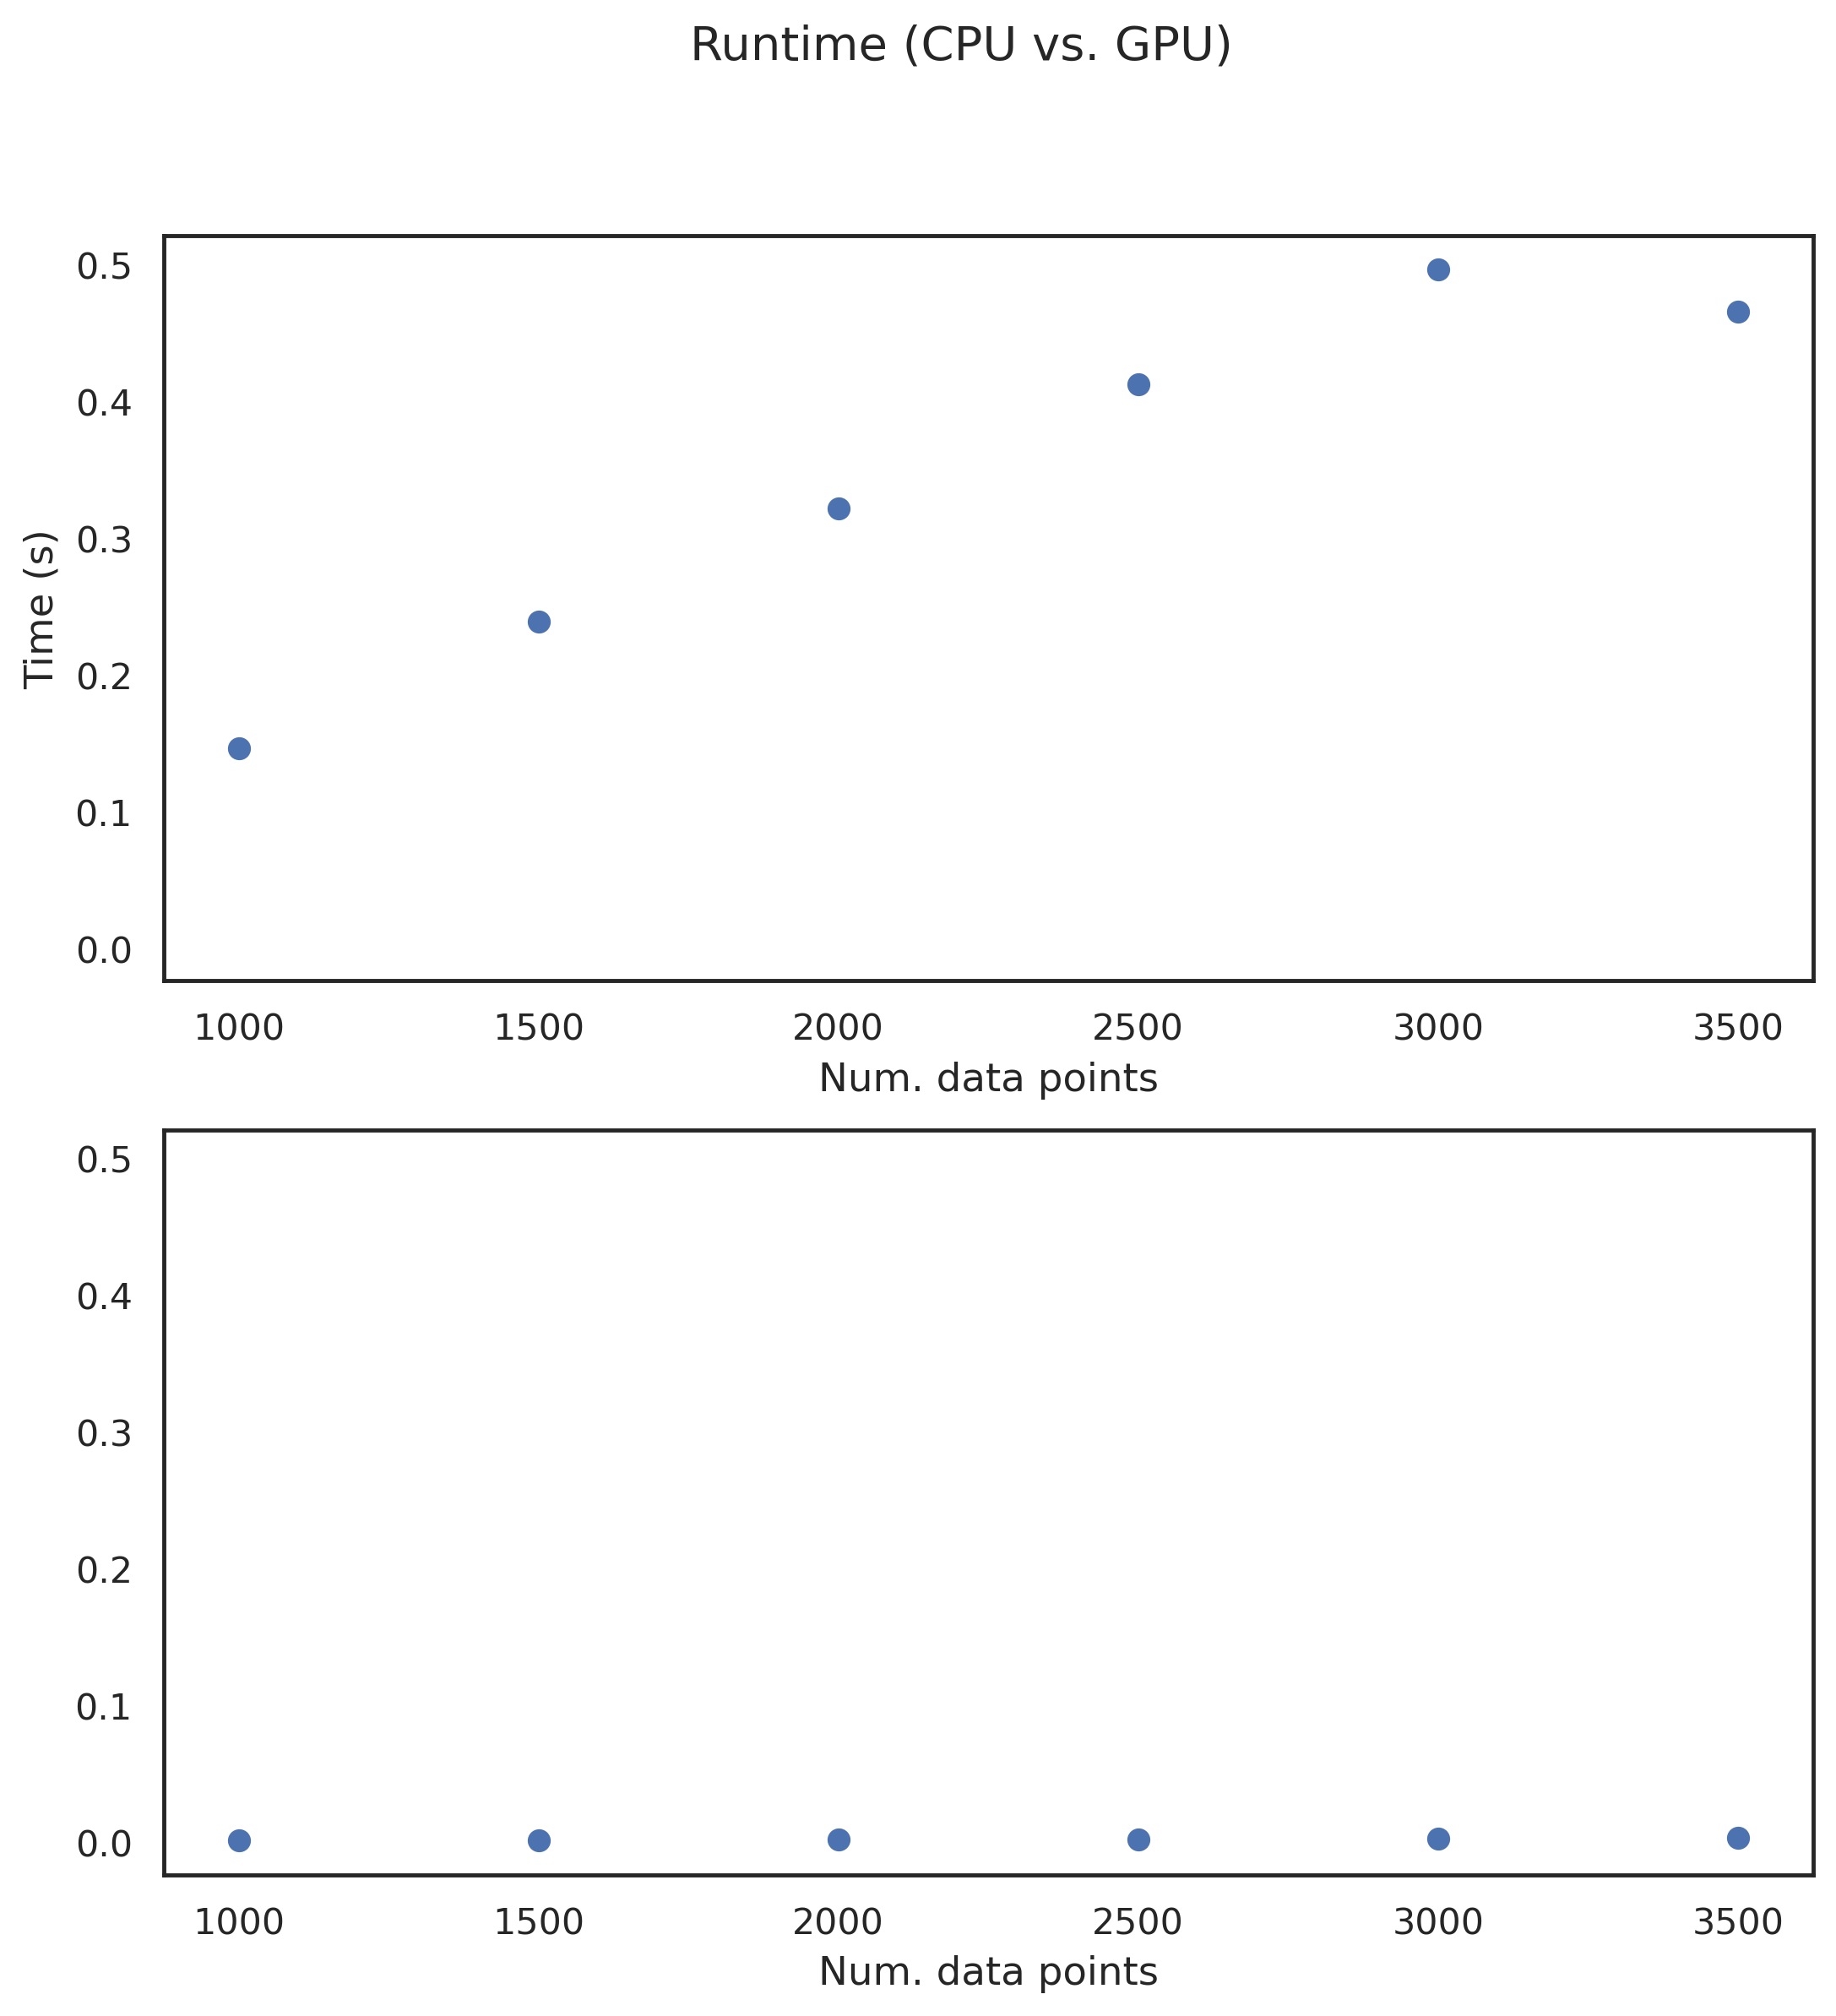

In [17]:
# Benchmark function.
def _importance_sampling(key, *args):
    inf = genjax.ImportanceSampling.new(1000, model)
    key, (trs, _, _) = inf.apply(key, *args)
    score = jnp.mean(trs.get_score())
    return key, score

def benchmark_is(key, num_data_points, device=jax.devices()[0]):
    x, y = make_data(num_data_points)
    observations = genjax.choice_map(
        {
            "ys": genjax.vector_choice_map(
                genjax.choice_map({("y", "value"): y})
            )
        }
    )
    key, times = benchmark(key,
        _importance_sampling, 
        observations, (x,), 
        device=device
    )
    return key, times

# Convenience which allows us to scale data and get times back
# for execution on a specific JAX-managed device.
def test_device(key, data_counts, device):
    times = []
    for data_count in data_counts:
        key, ts = %time benchmark_is(key, data_count, device=device)
        m = np.mean(ts)
        times.append(m)
        
    return key, np.array(times)

# Benchmarking.
data_counts = [1000, 1500, 2000, 2500, 3000, 3500]
f, axes = plt.subplots(1, 2, sharey=True, dpi=280)
cpu_ax = axes[0]
gpu_ax = axes[1]
cpu_ax.set_ylabel("Time (s)")
cpu_ax.set_xlabel("Num. data points")
gpu_ax.set_xlabel("Num. data points")
key, cpu_times = test_device(key, data_counts, cpu_device)
key, gpu_times = test_device(key, data_counts, gpu_device)
cpu_ax.scatter(data_counts, cpu_times)
gpu_ax.scatter(data_counts, gpu_times)
f.suptitle("Runtime (CPU vs. GPU)")

plt.show()

## AD interfaces in GenJAX

Let's also study the performance characteristics of algorithms which utilize the AD interfaces.

In GenJAX, the interfaces are slightly different than Gen.jl -- GenJAX automatically defines a function called `unzip` for any generative function which implements `assess`.

In [18]:
key, scorer, returner = model.unzip(key, genjax.EmptyChoiceMap)

`model.unzip` requires a PRNG key and fixed choice map - and returns two functions.

The first `scorer` function accepts a choice map and arguments and returns a `score` (computed using `assess`). It's a convenient function to apply `jax.grad` to.

The second `returner` function accepts a choice map and arguments and returns the `retval` (again computed using `assess`). It provides an interface to compute gradients with respect to the return value of the generative function.

This implementation of the gradient interfaces explicitly breaks the compositionality which Gen defines for `choice_gradients` and `argument_gradients` - but it conforms with JAX typical idioms, and also supports higher-order AD.

It's a pragmatic decision - but ultimately one I'm unsettled by. I'd love to discuss this design decision further.

In [19]:
# A higher-level gradient API - it relies upon `unzip`,
# but provides convenient access to first-order gradients.
def choice_grad(self, key, trace, selection):
    fixed = selection.complement().filter(trace.strip())
    evaluation_point = selection.filter(trace.strip())
    key, scorer, _ = self.unzip(key, fixed)
    choice_gradient_tree = jax.grad(scorer)(evaluation_point, trace.get_args())
    return key, choice_gradient_tree

We can still expose `choice_grad` - but here, it's just a convenient wrapper around the global `unzip` and `jax.grad`.

### Implementing MAP

Here's a rough version "always accept" MAP using the gradient interfaces (there's some slight deviations between this code and the standard library version, for pedagogical reasons).

In [20]:
@dataclasses.dataclass
class MapUpdate(genjax.Pytree):
    selection: Selection
    tau: FloatArray

    def flatten(self):
        return (self.tau,), (self.selection,)

    def apply(self, key, trace):
        args = trace.get_args()
        gen_fn = trace.get_gen_fn()
        key, forward_gradient_trie = gen_fn.choice_grad(
            key, trace, self.selection
        )
        forward_values = self.selection.filter(trace.strip())
        forward_values = forward_values.strip()
        forward_values = jtu.tree_map(
            lambda v1, v2: v1 + self.tau * v2,
            forward_values,
            forward_gradient_trie,
        )
        key, (_, _, new_trace, _) = gen_fn.update(
            key, trace, forward_values, args
        )
        return key, (new_trace, True)

    def __call__(self, key, trace):
        return self.apply(key, trace)

## Benchmarking MAP initialization + MH/MALA chain

Let's consider inference utilizing MAP initialization followed by MALA/MH moves.

In [21]:
map_move = genjax.map_update(genjax.select(["alpha"]), 0.001)
mala_move = genjax.mala(genjax.select(["alpha"]), 0.001)
mala_move

MetropolisAdjustedLangevinAlgorithm
├── selection
│   └── BuiltinSelection
│       └── trie
│           └── Trie
│               └── :alpha
│                   └── AllSelection
└── tau
    └── (const) 0.001

For MH, we'll define a proposal which targets the `"outlier"` random variable.

In [22]:
@genjax.gen
def proposal(chm):
    is_outlier = trace("outlier", genjax.Bernoulli)(0.1)


mh_move = genjax.mh(genjax.select(["outlier"]), proposal)
mh_move

MetropolisHastings
├── selection
│   └── BuiltinSelection
│       └── trie
│           └── Trie
│               └── :outlier
│                   └── AllSelection
└── proposal
    └── BuiltinGenerativeFunction
        └── source
            └── <function proposal>

### Chain idioms in JAX

Now we can create two chain functions, one for the MAP initialization and one for the MALA/MH moves.

We'll use `jax.lax.scan` to create chains of kernel applications. This is a control flow primitive which expresses a fold-like pattern of computation - and lowers to an efficient XLA loop nest.

As part of the `jax.lax.scan` call, we can return the current trace out and create a sequence -- we'll use this sequence to animate the moves below.

In [23]:
def map_chain(key, initial_trace, length):
    def _inner(carry, xs):
        key, current = carry
        key, (new, _) = map_move(key, current)
        return (key, new), new

    (key, new), sequence = jax.lax.scan(
        _inner, (key, initial_trace), None, length=length
    )
    return (key, new), sequence


def rejuv_chain(key, initial_trace, length):
    def _inner(carry, xs):
        key, current = carry
        key, (new, _) = mh_move(key, current, ())
        key, (new, _) = mala_move(key, new)
        return (key, new), new

    (key, new), sequence = jax.lax.scan(
        _inner, (key, initial_trace), None, length=length
    )
    return (key, new), sequence


def mixed_inf(key, initial_trace, length=50):
    (key, new), map_sequence = map_chain(key, initial_trace, length)
    (key, new), rejuv_sequence = rejuv_chain(key, new, length)
    return (key, new), (map_sequence, rejuv_sequence)

We'll also define a benchmark function for this inference variant.

In [24]:
def _mixed_inf(key, initial_trace):
    (key, new), _ = mixed_inf(key, initial_trace, length=50)
    score = new.get_score()
    return key, score


def benchmark_mixed(key, num_data_points, device=jax.devices()[0]):
    x, y = make_data(num_data_points)
    observations = genjax.choice_map(
        {
            "ys": genjax.vector_choice_map(
                genjax.choice_map({("y", "value"): y})
            )
        }
    )
    key, (_, initial) = jax.jit(model.importance)(key, observations, (x,))
    key, times = benchmark(key, _mixed_inf, initial, device=device)
    return key, times

In [25]:
key, times = benchmark_mixed(key, 200)
(np.mean(times), np.var(times))

(0.014963500499725342, 5.133860151431689e-08)

## Importance sampling with MH/MALA rejuvenation

We can easily lift the previous chain functions to map across the particle collection returned by importance sampling using `jax.vmap`

In [26]:
# Benchmark function.
def _importance_sampling_rejuv(key, *args):
    inf = genjax.ImportanceSampling.new(1000, model)
    key, (trs, _, lmle) = inf.apply(key, *args)
    key, trs = rejuv_chain(key, trs)
    key, sub_keys = genjax.slice(key, 1000)
    (_, new), _ = jax.vmap(mixed_inf, in_axes=(0, 0))(sub_keys, trs)
    score = jnp.mean(trs.get_score())
    return key, score